# Mandelbrot Set Visualizer
#### V. Hunter Adams (vha3@cornell.edu)

#### Modified from [Bruce Land's Mandelbrot Lab](https://people.ece.cornell.edu/land/courses/ece5760/LABS/s2019/lab3_mandelbrot.html)

In [102]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [106]:
import numpy
import matplotlib.pyplot as plt
from IPython.display import HTML
plt.rcParams["figure.figsize"] = (10,3)
from ipywidgets import interactive
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

> - [Introduction](#Introduction)
> - [Mathematical background](#Mathematical-background)
> > - [Video discussion of mathematical background](#Video-discussion-of-mathematical-background)
> > - [A simple iteration](#A-simple-iteration)
> > - [The same iteration with complex numbers](#The-same-iteration-with-complex-numbers)
> > - [A slight modification to the complex iteration](#A-slight-modification-to-the-complex-iteration)
> > - [Increasing resolution and colorizing](#Increasing-resolution-and-colorizing)
> - [Weekly checkpoints and lab report](#Weekly-checkpoints-and-lab-report)
> > - [Week One](#Week-One)
> > - [Week Two](#Week-Two)
> > - [Week Three](#Week-Three)
> > - [Lab Report](#Lab-Report)
> - [References](#References)


## Introduction

In this lab, you will calculate and render the [Mandelbrot Set](https://en.wikipedia.org/wiki/Mandelbrot_set), one of the most beautiful and interesting structures in mathematics. I can't explain why the Mandelbrot Set is beautiful (it's hard to know what, precisely, makes something beautiful), but here are some reasons that it's interesting:

- The edge of the Mandelbrot Set is *infinitely rough*. That means that you can zoom in on the edge of the set *forever* and you'll keep finding complicated (and beautiful) structures. In this lab, you'll be able to zoom in a distance of approximately $2^{14}$.
- This infinitely complex structure is generated by *shockingly simple rules.* The Mandelbrot Set is an example of complexity from simplicity. Meditating on that notion can take your mind to some interesting places, and lead you to some interesting reading.
- The edge of the Mandelbrot Set is connected. This was discovered by Adrien Douady and Cornell's John Hubbard.

You are challenged to compute and render the Mandelbrot Set on a 640x480 display *as fast as you can.* Each pixel on the display will map to a point on the complex plane at which you will run the iteration which generates the Mandelbrot Set. You will colorize that pixel according to the number of iterations that it takes to reach a threshold magnitude, and then move on to the next pixel. Last year, the fastest groups were able to compute and render the whole set in ~35 ms. Your user interface will allow for you to *explore the edges of the set*. You'll be able to zoom and pan to find interesting structures. It is often the case that students spend many hours exploring the Mandelbrot Set, once they have their system working.

To accelerate calculation, you will want to parallelize as many iterators as possible on the FPGA. You will likely find that your limiting resource for parallization is multipliers. Think carefully about load balancing among all of your solvers.

To accelerate rendering, think carefully about serial bottlenecks. How are you going to dispatch pixels to each solver? How are you going to write to the VGA screen from many solvers with limited contention among those solvers?

<iframe width="560" height="315" src="https://www.youtube.com/embed/s-EJJK9lSTM" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## Mathematical background

The Mandelbrot set is simply too interesting and too lovely to introduce as a set of equations for implementation. So, before we discuss how we'll implement this on the FPGA, I want to first attempt to explain what the Mandelbrot set is and why it's interesting.

### Video discussion of mathematical background

<iframe width="560" height="315" src="https://www.youtube.com/embed/47sJEYMBIZw" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### A simple iteration

The train of thought that leads to the Mandelbrot set begins with thinking about iterations. An iteration is simply a rule which we apply over and over again. So, for example, the iteration below tells us to start with some number, $x_0$, and to square it repeatedly. If $x_0$ is 2, then $x_1$ is 4, $x_2$ is 16, etc.

\begin{align}
x_{N+1} &= x_N^2
\end{align}

Now ask the following question: **for which choices of $x_0$ does this iteration remain stable (not go to infinity), and for which choices of $x_0$ does it go to infinity?** Is it obvious that, for this iteration, any $x_0$ in the range [-1,1] is stable, and any $x_0$ outside that range is unstable? We could color the parts of the real number line which are stable as shown below.<br><br>

<figure>
    <img align="center" width="800" height="500" src="line.png" alt='missing' />
    <center><figcaption></figcaption></center>
</figure>

### The same iteration with complex numbers

Let's consider almost the same iteration, except we'll allow for our numbers to be complex. Instead of representing our numbers on the real number line, we represent them in the complex plane. Our numbers can have real parts and imaginary parts.

\begin{align}
z_{N+1} &= z_N^2
\end{align}

As before, the question is: **for which choices of $z_0$ does this iteration remain stable (not go to infinity), and for which choices of $z_0$ does it go to infinity?** As many of you will recall, when you square a complex number with magnitude less than one (i.e. a number that is less than one unit from the origin of the complex plane), the resulting complex number has a smaller magnitude. This is the complex extension of the iteration above. So, the region of stability for this iteration is a circle with radius 1 centered at the origin.

Suppose that you couldn't figure out what this region of stability looked like. One strategy that you might deploy in order to get a sense for it might be to populate the complex plane with test points, and then to run the iteration on each of those test points. If you run the iteration some large number of times (say, 1000) and the magnitude of the complex number still hasn't gone above some threshold value (in particular, 2, for reasons that are beyond the scope of this document), then we'll assume that particular point is inside the region of stability. If it exceeds that threshold value, we'll assume it's outside the region of stability.

For example, consider the array of test points below. We'll run the above iteration on each of these test points. If the iteration diverges at that point, we'll ignore it. If it converges, we'll mark it with an x. This way, we can get a visual sense for what the region of stability looks like.

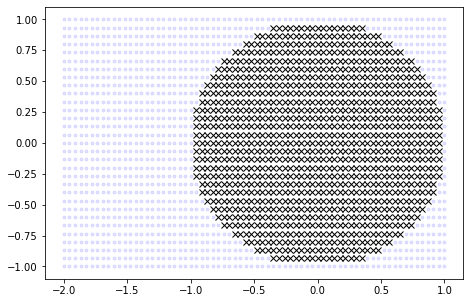

In [96]:
x = numpy.linspace(-2, 1, 70)
y = numpy.linspace(-1, 1, 31)
X, Y = numpy.meshgrid(x, y)
plt.figure(2, figsize=(7.5, 5))
for i in x:
    for j in y:
        xiter = i
        yiter = j
        newx = xiter
        newy = yiter
        count = 0
        while(count<1000 and (newx**2. + newy**2. < 1)):
            newx = xiter**2. - yiter**2.
            newy = 2*xiter*yiter
            xiter = newx
            yiter = newy
            count += 1
        if (count==1000):
            plt.plot(i, j, marker='x', color='black')
        else:
            plt.plot(i, j, 'b.', alpha=0.1)
plt.show()

As expected, we get a low resolution approximation for a *circle* of radius 1, centered at the origin of the complex plane.

### A slight modification to the complex iteration

Let us now consider an iteration that is almost the same as the above iteration. We'll assume that $z_0$ is 0, but we'll add some complex constant $c$ every time we update the iteration.

\begin{align}
z_{N+1} = z_{N}^2 + c && \text{where  }z_0 = 0
\end{align}

Similar to before, the question is: **for which choices of $c$ does this iteration remain stable (not go to infinity), and for which choices of $c$ does it go to infinity?** Like we did for the previous iteration, let us populate the complex plane with test points to attempt to get an understanding for what this region of stability looks like. When we run this iteration for each test point and mark those that converge with an x, we get the following image:

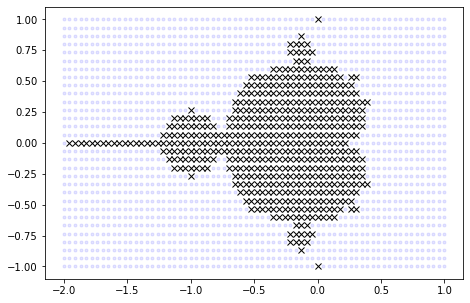

In [97]:
plt.figure(2, figsize=(7.5, 5))
for i in x:
    for j in y:
        xiter = 0
        yiter = 0
        newx = xiter
        newy = yiter
        count = 0
        while(count<10000 and (newx**2. + newy**2. < 4)):
            newx = xiter**2. - yiter**2. + i
            newy = 2*xiter*yiter + j
            xiter = newx
            yiter = newy
            count += 1
        if (count==10000):
            plt.plot(i, j, marker='x', color='black')
        else:
            plt.plot(i, j, 'b.', alpha=0.1)
plt.show()

*What the hell is that?* Benoit Mandelbrot would have asked himself the same thing when this came out of the printer in IBM. It is not obvious at this resolution what the edge of this region of convergence looks like. But, in the late 70's, this is the level of resolution that computers were capable of visualizing in reasonable amounts of time.

### Increasing resolution and colorizing

The first ever published image of the Mandelbrot set is shown below left, at approximately the same resolution as it is shown in the previous section. As computers became more powerful, this iteration could be run on more and more test points, increasing the resolution for this region of stability. Below center is the *same picture*, but with more test points. Images like the ones below have since become some of the most famous in mathematics. Often, you'll see them drawn not just in black and white, but with the unstable points colored in proportion to how unstable they are. (Did the point diverge in 2 iterations? If so, color it some color. Did it take 20 iterations? Color it a different color. 500 iterations? A different color again.) These colorizations yield images like that shown below right.

A | B | C
- | - | -
<img align="center" width="400" height="500" src="First.png" alt='missing' /><center><figcaption>Fig. 2 from [1]</figcaption></center> | <img align="center" width="400" height="500" src="two.png" alt='missing' /><center><figcaption>Same image, with more test points</figcaption></center> | <img align="center" width="400" height="500" src="three.png" alt='missing' /><center><figcaption>Unstable points colorized</figcaption></center>

## Weekly checkpoints and lab report

#### Week One
- Read the [Mandelbrot Implementation Background](./Mandelbrot_Implementation.html) webpage.
- Demonstrate a simulation of one complex iterator pipeline in synthesizable Verilog running in ModelSim. The number of iterations required should match that returned by a Matlab or Python implementation (see the implementation webpage linked in the first bullet).
> - For the custom hardware, I suggest using a minimum of 4.23 [fixed point notation](https://vha3.github.io/FixedPoint/FixedPoint.html) for interating the quadratic complex number calculation. The number of bits carried will limit the zoom depth. Every bit gives one level of zoom, but you need 10 bits to represent the screen width, so 23 bits gives only 13 zoom levels. The top bit will be the usual 2's comp sign bit. The 4.23 notation means that a single DSP unit can do one multiply. This format give the numbers a dynamic range of +/-7.
> - Make sure you test at a variety of points (some in the set, some outside the set, some positive, some negative). Do not continue until you have convinced yourself, beyond any shadow of doubt, that your iterator is working properly.
- Download, run, and time the Mandelbrot example on the [University computer graphics](https://people.ece.cornell.edu/land/courses/ece5760/DE1_SOC/HPS_peripherials/univ_pgm_computer.index.html) webpage. *This is the baseline performance that you **must beat** with the FPGA*.
- You need the best HPS time for comparision to FPGA solution time.

#### Week Two

- Demo *more than one* complex iterator writing to the VGA display to show full Mandelbrot Set on the VGA. There are a few options for how you might do this. Some are slower (but easier) and others are faster (but harder). Consider getting one of the slower options working, and then optimizing to a faster option.
> - You could write to the VGA subsystem using a bus master. This is slow because it requires a bus transaction for each pixel, and it introduces a serial bottleneck among the parallel solvers (since the bus master can only send color data from one solver at a time to the VGA subsystem). To pursue this option, see ***VGA display using a bus_master as a GPU for the HPS. Display from SDRAM.*** on the [bus master webpage](https://people.ece.cornell.edu/land/courses/ece5760/DE1_SOC/HPS_peripherials/Bus_master_slave_index.html).
> - You could have each parallel solver write directly to Qsys VGA display memory. This is faster than the first option because it avoids bus master transactions. However, there is still a serial bottleneck associated with writing to the display memory. An arbiter must schedule memory writes among all parallel solvers. To pursue this option, see ***GPU with FAST display from SRAM*** on the [bus master webpage](https://people.ece.cornell.edu/land/courses/ece5760/DE1_SOC/HPS_peripherials/Bus_master_slave_index.html).
> - The fastest option is to have each solver write to *its own* M10k memory block, and to have a custom VGA driver multiplex into those M10k blocks. This eliminates the serial bottlneck associated with writing to memory. [Here is a VGA driver](https://vha3.github.io/DE1/VGA_Driver/Driver.html) to get you started.
- The computation must be a bus-master output directly to the VGA bus-slave, and not pass results through the HPS. The VGA graphics interface should run the VGA at 640x480 resolution with at least 8-bit color per pixel. Colors may aid in debugging and certainly look cool. You may want to map color to the number of iterations to divergence, or to the log of that number. A reasonable approximation of the log is to just use the position of the largest non-zero bit in the count. Here's a color scheme I like based on the [Commodore 64 Palette](https://lospec.com/palette-list/commodore64).
```verilog
if (counter >= max_iterations) begin
    color_reg <= 8'b_000_000_00 ; // black
end
else if (counter >= (max_iterations >>> 1)) begin
    color_reg <= 8'b_011_001_00 ; // white
end
else if (counter >= (max_iterations >>> 2)) begin
    color_reg <= 8'b_011_001_00 ;
end
else if (counter >= (max_iterations >>> 3)) begin
    color_reg <= 8'b_101_010_01 ;
end
else if (counter >= (max_iterations >>> 4)) begin
    color_reg <= 8'b_011_001_01 ;
end
else if (counter >= (max_iterations >>> 5)) begin
    color_reg <= 8'b_001_001_01 ;
end
else if (counter >= (max_iterations >>> 6)) begin
    color_reg <= 8'b_011_010_10 ;
end
else if (counter >= (max_iterations >>> 7)) begin
    color_reg <= 8'b_010_100_10 ;
end
else if (counter >= (max_iterations >>> 8)) begin
    color_reg <= 8'b_010_100_10 ;
end
else begin
    color_reg <= 8'b_010_100_10 ;
end
```
- Display the time to render either on the VGA screen, or a serial console.
- Demonstrate interactive zooming and panning on the VGA.

#### Week Three

- You may use HPS for control, but you do not have to.
- The corners of the region being plotted should be displayed either on the VGA screen, or on a serial console.
- You should be able to choose the maximum number of iterations using serial input the HPS, or toggle switches, or however you want to do it.
- Upon pressing KEY0, the system should compute and display the full Mandelbrot set, as shown above.
- There will be a zoom interface using push buttons, or serial communication to a terminal or a mouse interface. It is sufficient to use a center coordinate anywhere in the displayed range and zoom in/out by a factor of two. When you trigger the zoom calculation, the specified corners should be reassigned to the corners of the display and 640x480 new points in those intervals should be iterated again.
> - You will be evaluated on your project's usability! Think carefully about user interface. The mouse is, I think, the most fun and intuitive way to explore the set.
- Part of your grade will depend upon how fast you can render the full 640x480 set and two other regions picked on demo day.
- The elapsed time to draw the screen (in milliseconds) should be shown on the VGA screen or on the HPS console. 
- You will need to show how your solution time for the full set depends on the number of solver pipelines used.

#### Lab Report

Your written lab report should include the sections mentioned in the [policy page](https://people.ece.cornell.edu/land/courses/ece5760/policy.html), and :

- What determines how deep you can zoom?
- A table of times to compute various regions of the Mandelbrot set close to the areas specified in the list.
\begin{align}
x=[-2,1] && &y=[-1,1]\\
x=[-0.758,-0.75]&& &y=[0.05,0.06]\\
x=[-1.45, -1.3]&& &y=[-0.07, 0.07]
\end{align}
- A collection of photographs of your favorite regions, and their coordinates. The camera should be good enough to resolve individual pixels.
- A table of your solution time for the full set versus the number of solver pipelines used and for FPGA solution versus HPS solution time.
- A detailed description of your Qsys design.
- A heavily commented listing of your Verilog design (for FPGA) and GCC code (for HPS).

## References

1.  Brooks, Robert and Matelski, J. Peter. "The Dynamics of 2-Generator Subgroups of PSL(2, ℂ)". Riemann Surfaces Related Topics (AM-97), Volume 97: Proceedings of the 1978 Stony Brook Conference. (AM-97), edited by Irwin Kra and Bernard Maskit, Princeton: Princeton University Press, 2016, pp. 65-72. https://doi.org/10.1515/9781400881550-007
2. [What's so special about the Mandelbrot Set - Numberphile](https://www.youtube.com/watch?v=FFftmWSzgmk)

In [108]:
# num=100
# def f(Zr, Zi, c, d):
#     plt.figure(2, figsize=(10, 10))
#     x = list(numpy.zeros(num))
#     y = list(numpy.zeros(num))
#     x[0] = Zr
#     y[0] = Zi
#     for i in range(1, num):
#         x[i] = x[i-1]**2. - y[i-1]**2. + c*numpy.cos(d)
#         y[i] = 2*x[i-1]*y[i-1] + c*numpy.sin(d)
#     plt.plot(x, y, 'b-', alpha=0.1)
#     plt.plot(numpy.linspace(-1.5, 1.5, 100), numpy.zeros(100), color='black', alpha=0.2)
#     plt.plot(numpy.zeros(100), numpy.linspace(-1.5, 1.5, 100), color='black', alpha=0.2)
#     plt.plot(x, y, 'r.')
#     plt.xlabel('Real', fontsize=18)
#     plt.ylabel('Imaginary', fontsize=18)
#     plt.plot(c*numpy.cos(d), c*numpy.sin(d), 'b*')
# #     circle = numpy.linspace(0, 2*numpy.pi, 100)
# #     plt.plot(numpy.cos(circle), numpy.sin(circle))
#     plt.plot(x[0], y[0], 'g*')
#     plt.ylim(-1.5, 1.5)
#     plt.xlim(-1.5 ,1.5)

# interactive_plot = interactive(f, Zr=(-2.0, 2.0, .01), Zi=(-2.0, 2.0, .01),
#                                c=(0.0, 2.0, 0.01), d=(0.0, 2*numpy.pi, 0.001))
# output = interactive_plot.children[-1]
# output.layout.height = '600px'
# interactive_plot